# Sparse/Dense QUBO Matrix in OpenJij
The number of nonzero elements in the interaction matrix $J$ of the Ising Hamiltonian or QUBO matrix $Q$ can vary greatly depending on the problem.
Many real-life problems have sparse interaction matrices with relatively few nonzero values.
Therefore, by default, OpenJij internally keeps the interaction coefficients as a sparse matrix.
However, depending on the problem, many elements of the interaction matrix may be non-zero.
In this case, data retention in sparse matrix form will slow down the computation.
To solve this problem, OpenJij provides a parameter, `sparse`, that allows users to control how the matrix is retained.
In this tutorial, we will explain how to use `sparse`. We will also compare the speed of keeping data in a sparse matrix with that of keeping data in a dense matrix.

In [1]:
import openjij as oj
import numpy as np
import time

The internal retention of data can be configured as follows:
```python
sampler = oj.SASampler()
response = sampler.sample_ising(h, J, sparse = True)
```
With `sparse = True`, the sampler retains the interaction matrix as a sparse matrix.
The latest OpenJij has `sparse = True` by default (as of 2022/10 (v0.6.5)).
You can change this flag by:
```python
response = sampler.sample_ising(h, J, sparse = False)
```
This would make internal data retention a dense matrix.

## Comparing Execution Speed in Sparse and Dense Mode
Next, let us examine how data retention can affect execution time.

In [2]:
NUM_READS = 1

BETA_MAX = 14000000
BETA_MIN = 0.0015

num_spins = [100,200,500,1000,2000,5000]
p_list = [0.1,0.3,0.5,0.8]

A variant of the Sherrington-Kirkpatrick (SK) model without external fields is used here as a benchmark.
The SK model without external fields is a model with the following Hamiltonian:

$$ H = \frac{1}{N}\sum_{ij} J_{ij} \sigma_i \sigma_j,\\ \ J_{ij} \sim \mathcal{N}(0,1), J_{ij} = J_{ji}$$

where $\mathcal{N}(0,1)$ is a random Gaussian noise with a mean of 0 and variance of 1.
In the SK model, all elements follow a random distribution.
However, here we will examine how computation time changes as we vary the fraction of elements in the interaction matrix $J$ and make the interaction sparse.

First, we set up a random interaction. Here, the parameters are the number of spins $n$ and the fraction of elements $p$ in the interaction matrix $J$.

In [3]:
def create_random_interaction(n,p):
    h,J = {},{}
    for i in range(n-1):
        for j in range(i+1, n):
            if np.random.random() <= p:
                # OpenJij keeps data in the form of an upper triangular matrix.
                J[i, j] = np.random.normal(0, 1) / np.sqrt(n)

    return J,h

We first calculate the case with a dense matrix.
Here, we change the number of spins $n=100,200,500,1000,2000,5000$, and the proportion of elements $p$ in the interaction matrix $J$ is also varied $p=0.1,0.3,0.5,0.8$.

In [4]:
# Benchmark OpenJij Dense
print('OpenJij Dense')
sampler = oj.SASampler()
openjij_dense_time = []
openjij_dense_energy = []

for p in p_list:
    for n in num_spins:
        J,h = create_random_interaction(n,p)
        start = time.perf_counter()
        response = sampler.sample_ising(h, J, num_sweeps=1000, num_reads=NUM_READS, beta_max=BETA_MAX, beta_min=BETA_MIN, sparse = False)
        elapsed_time = time.perf_counter() - start

        openjij_dense_time.append(elapsed_time)
        openjij_dense_energy.append(np.mean(response.energies))

        print(f"p = {p}, n = {n} : \telapsed_time:{elapsed_time}[sec]")

OpenJij Dense
p = 0.1, n = 100 : 	elapsed_time:0.010784893999999934[sec]
p = 0.1, n = 200 : 	elapsed_time:0.026233769000000073[sec]
p = 0.1, n = 500 : 	elapsed_time:0.21190827999999984[sec]
p = 0.1, n = 1000 : 	elapsed_time:0.6879572889999999[sec]
p = 0.1, n = 2000 : 	elapsed_time:2.9189378899999996[sec]
p = 0.1, n = 5000 : 	elapsed_time:17.226335605999996[sec]
p = 0.3, n = 100 : 	elapsed_time:0.011216662999999016[sec]
p = 0.3, n = 200 : 	elapsed_time:0.02720410599999923[sec]
p = 0.3, n = 500 : 	elapsed_time:0.1655943339999979[sec]
p = 0.3, n = 1000 : 	elapsed_time:0.7373647790000035[sec]
p = 0.3, n = 2000 : 	elapsed_time:2.9717210430000023[sec]
p = 0.3, n = 5000 : 	elapsed_time:18.64540647900001[sec]
p = 0.5, n = 100 : 	elapsed_time:0.009729735999997047[sec]
p = 0.5, n = 200 : 	elapsed_time:0.03336171099999774[sec]
p = 0.5, n = 500 : 	elapsed_time:0.18042641499999945[sec]
p = 0.5, n = 1000 : 	elapsed_time:0.8616806240000017[sec]
p = 0.5, n = 2000 : 	elapsed_time:5.395520128000001[sec]

Next, we examine the case with a sparse matrix.
The execution conditions are the same as for the dense matrix case.

In [5]:
# Benchmark OpenJij Sparse
print('OpenJij Sparse')
sampler = oj.SASampler()
openjij_sparse_time = []
openjij_sparse_energy = []
for p in p_list:
    for n in num_spins:
        J,h = create_random_interaction(n,p)
        start = time.perf_counter()
        response = sampler.sample_ising(h, J, num_sweeps=1000, num_reads=NUM_READS, beta_max=BETA_MAX, beta_min=BETA_MIN, sparse=True)
        elapsed_time = time.perf_counter() - start

        openjij_sparse_time.append(elapsed_time)
        openjij_sparse_energy.append(np.mean(response.energies))

        print(f"p = {p}, n = {n} : \telapsed_time:{elapsed_time}[sec]")

OpenJij Sparse
p = 0.1, n = 100 : 	elapsed_time:0.015455876999993734[sec]
p = 0.1, n = 200 : 	elapsed_time:0.01172593000001143[sec]
p = 0.1, n = 500 : 	elapsed_time:0.05383983299998363[sec]
p = 0.1, n = 1000 : 	elapsed_time:0.18197211800000446[sec]
p = 0.1, n = 2000 : 	elapsed_time:0.727910971[sec]
p = 0.1, n = 5000 : 	elapsed_time:4.896766718999999[sec]
p = 0.3, n = 100 : 	elapsed_time:0.007563688999994156[sec]
p = 0.3, n = 200 : 	elapsed_time:0.023680912000003218[sec]
p = 0.3, n = 500 : 	elapsed_time:0.12488942999999608[sec]
p = 0.3, n = 1000 : 	elapsed_time:0.663864641999993[sec]
p = 0.3, n = 2000 : 	elapsed_time:2.272948852999974[sec]
p = 0.3, n = 5000 : 	elapsed_time:14.29901092199998[sec]
p = 0.5, n = 100 : 	elapsed_time:0.012703374000011536[sec]
p = 0.5, n = 200 : 	elapsed_time:0.052227919000017664[sec]
p = 0.5, n = 500 : 	elapsed_time:0.19213491300001806[sec]
p = 0.5, n = 1000 : 	elapsed_time:0.8431962399999975[sec]
p = 0.5, n = 2000 : 	elapsed_time:3.5385885899999607[sec]
p = 

Let us plot the results.

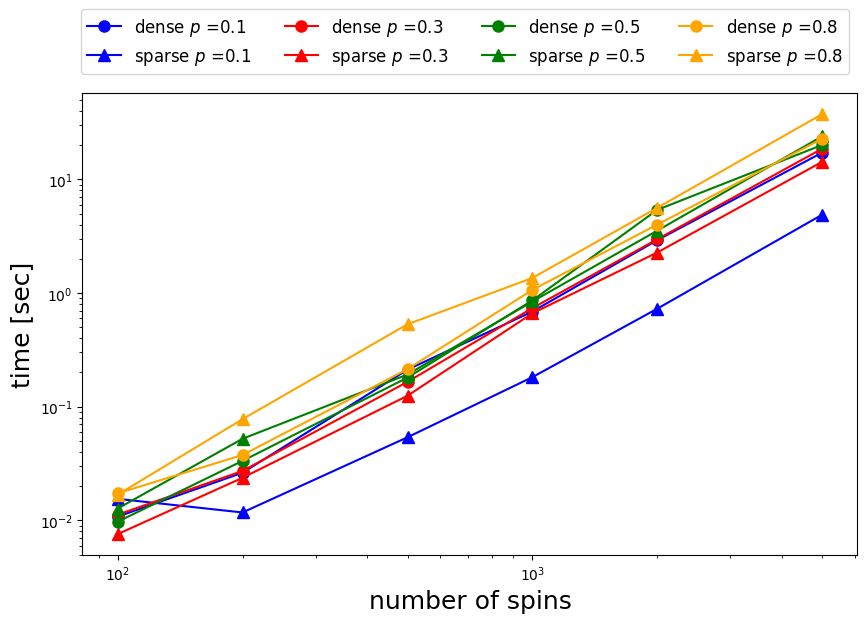

In [6]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,6))
sparse_time = np.array(openjij_sparse_time).reshape(len(p_list),-1)
dense_time = np.array(openjij_dense_time).reshape(len(p_list),-1)
color_list = ["blue", "red", "green", "orange"]
for index,p in enumerate(p_list):
    plt.plot(num_spins,dense_time[index], '-o', label=f'dense $p$ ={p}', color = color_list[index], markersize=8)
    plt.plot(num_spins,sparse_time[index], '-^', label=f'sparse $p$ ={p}', color = color_list[index], markersize=8)
plt.xscale("log")
plt.yscale("log")
plt.xlabel('number of spins', fontsize=18)
plt.ylabel('time [sec]', fontsize=18)
plt.legend(fontsize=12, ncol = 4, bbox_to_anchor=(0.7, 0.7, 0.3, 0.5))
plt.show()

When the fraction of elements packed in the interaction matrix is $p=0.1$, the sparse matrix case with `sparse=True` is several times faster than the dense matrix case.
However, at around $p=0.3$, both speeds are approximately the same.
Furthermore, the dense matrix is faster when $p=0.5,0.8$.
Thus, we can see that execution speed varies depending on whether a sparse or dense matrix is used.
As a result, you will achieve faster results by switching accordingly to the problems.